### 1 Install the packages

In [1]:
! pip install matplotlib inequality libpysal geopandas requests pandas mapclassify numpy

### 2 Import the packages

In [2]:
import matplotlib.pyplot as plt
import inequality
import libpysal
import geopandas as gpd
import pandas as pd
import json
import requests
import numpy as np
from libpysal.weights import Queen, Rook, KNN


### 3 Load the census tract in harris county and take a look at it

--2022-04-06 23:01:32--  https://raw.githubusercontent.com/ChunwuZhu/SPTP_lab/main/harris.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6155948 (5.9M) [text/plain]
Saving to: ‘harris.geojson’

harris.geojson      100%[===================>]   5.87M  --.-KB/s    in 0.1s    

2022-04-06 23:01:32 (59.7 MB/s) - ‘harris.geojson’ saved [6155948/6155948]



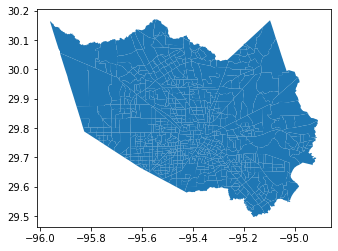

In [4]:
!wget https://raw.githubusercontent.com/ChunwuZhu/SPTP_lab/main/harris.geojson
harris = gpd.read_file(
    "./harris.geojson"
)
harris.plot()

In [5]:
harris.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,Shape_Leng,Shape_Area,Area,area_km,date,F2_15_2021,ObjectID,geoid_1,during_dis,robust,ObjectID_1,region,geometry
0,48,201,550301,48201550301,0.087945,0.000266,2.841116,2.841116,48201550301,-0.592180,695,48201550301,115.929204,58.702065,718,2,"MULTIPOLYGON (((-95.43727 29.98103, -95.43709 ..."
1,48,201,550302,48201550302,0.128726,0.000833,8.905305,8.905305,48201550302,-0.633229,696,48201550302,141.739622,62.993505,720,2,"MULTIPOLYGON (((-95.46369 30.00709, -95.45908 ..."
2,48,201,550401,48201550401,0.136356,0.000941,10.062362,10.062362,48201550401,-0.562786,697,48201550401,138.179285,55.945193,719,2,"MULTIPOLYGON (((-95.48469 29.99539, -95.48391 ..."
3,48,201,553403,48201553403,0.164595,0.000623,6.659484,6.659484,48201553403,-0.623691,740,48201553403,205.497382,61.910995,660,2,"MULTIPOLYGON (((-95.49277 30.05046, -95.49212 ..."
4,48,201,454502,48201454502,0.118936,0.000706,7.573661,7.573661,48201454502,-0.843546,545,48201454502,289.164786,84.198646,119,1,"MULTIPOLYGON (((-95.73361 29.73627, -95.73338 ..."


### 4 Get ACS data using api


In [6]:
def get_acs_data(year,type,fields,tract,state,county,key):
    api_url = 'https://api.census.gov/data/{}/acs/{}?get=NAME,{}&for=tract:{}&in=state:{}&in=county:{}&key={}'.format(year,type,list(fields.keys())[0],tract,state,county,key)
    html = requests.get(api_url)
    res = json.loads(html.content)
    df_res = pd.DataFrame(res[1:])
    column = res[0]
    column[1] =list(fields.values())[0]
    df_res.columns = column
    df_res['geoid'] = df_res['state'].astype(str)+df_res['county'].astype(str)+df_res['tract'].astype(str)
    df_res['geoid'] = df_res['geoid'].astype('str')
    df_res[list(fields.values())[0]] = df_res[list(fields.values())[0]].astype('float')
    return df_res

### 5 Get median household income for census tract in harris county for the year 2019

In [7]:
year = "2019"
fields = {'B19013_001E':'MHI_{}'.format(year)}
inc_2019 = get_acs_data(year=year,type="acs5",fields=fields,tract="*",state="48", county='201', key='77908019f81f76b439f9eac11a6918582f81ff7f')
inc_2019

,NAME,MHI_2019,state,county,tract,geoid
0,"Census Tract 5424, Harris County, Texas",67166.0,48,201,542400,48201542400
1,"Census Tract 5507, Harris County, Texas",66724.0,48,201,550700,48201550700
2,"Census Tract 5514, Harris County, Texas",79122.0,48,201,551400,48201551400
3,"Census Tract 5525, Harris County, Texas",63906.0,48,201,552500,48201552500
4,"Census Tract 2107, Harris County, Texas",39047.0,48,201,210700,48201210700
...,...,...,...,...,...,...
781,"Census Tract 5421.01, Harris County, Texas",66587.0,48,201,542101,48201542101
782,"Census Tract 5421.02, Harris County, Texas",79424.0,48,201,542102,48201542102
783,"Census Tract 5423.01, Harris County, Texas",76268.0,48,201,542301,48201542301
784,"Census Tract 5423.02, Harris County, Texas",83477.0,48,201,542302,48201542302


### 6 Mapping the median household income in 2019 (MHI_2019) for tracts in harris county

In [8]:
### merge MHI_2019 to the geojson of harris county using geoid

inc = inc_2019[["MHI_2019",'geoid']]
harris = harris.rename(columns = {"GEOID":"geoid"})
harris = harris.merge(inc,how="inner",on='geoid')
harris.head()


,STATEFP,COUNTYFP,TRACTCE,geoid,Shape_Leng,Shape_Area,Area,area_km,date,F2_15_2021,ObjectID,geoid_1,during_dis,robust,ObjectID_1,region,geometry,MHI_2019
0,48,201,550301,48201550301,0.087945,0.000266,2.841116,2.841116,48201550301,-0.592180,695,48201550301,115.929204,58.702065,718,2,"MULTIPOLYGON (((-95.43727 29.98103, -95.43709 ...",30236.0
1,48,201,550302,48201550302,0.128726,0.000833,8.905305,8.905305,48201550302,-0.633229,696,48201550302,141.739622,62.993505,720,2,"MULTIPOLYGON (((-95.46369 30.00709, -95.45908 ...",47829.0
2,48,201,550401,48201550401,0.136356,0.000941,10.062362,10.062362,48201550401,-0.562786,697,48201550401,138.179285,55.945193,719,2,"MULTIPOLYGON (((-95.48469 29.99539, -95.48391 ...",50941.0
3,48,201,553403,48201553403,0.164595,0.000623,6.659484,6.659484,48201553403,-0.623691,740,48201553403,205.497382,61.910995,660,2,"MULTIPOLYGON (((-95.49277 30.05046, -95.49212 ...",88313.0
4,48,201,454502,48201454502,0.118936,0.000706,7.573661,7.573661,48201454502,-0.843546,545,48201454502,289.164786,84.198646,119,1,"MULTIPOLYGON (((-95.73361 29.73627, -95.73338 ...",204250.0


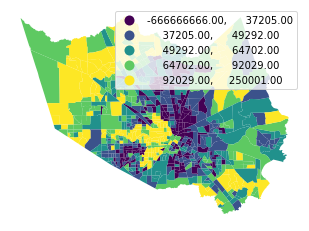

In [9]:
### mapping the median household income using quantiles 
ax = harris.plot(column='MHI_2019',k=5,scheme='Quantiles',legend=True)
ax.set_axis_off()


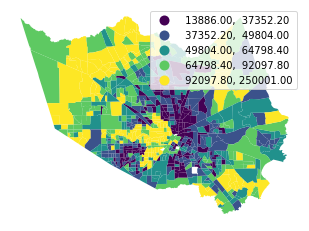

In [10]:
### remove those tract with -6666666
harris = harris.replace(-666666666,np.nan)
ax = harris.plot(column='MHI_2019',k=5,scheme='Quantiles',legend=True)
ax.set_axis_off()

### 7 Get ACS median household income for 2015 to 2018 and add it to the geojson

In [11]:
years = ['2015','2016','2017','2018']
for year in years:
  fields = {'B19013_001E':'MHI_{}'.format(year)}
  inc = get_acs_data(year=year,type="acs5",fields=fields,tract="*",state="48", county='201', key='77908019f81f76b439f9eac11a6918582f81ff7f')
  harris = harris.merge(inc,how="inner",on='geoid')
harris.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'state_x', 'county_x', 'NAME_x', 'tract_x'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


,STATEFP,COUNTYFP,TRACTCE,geoid,Shape_Leng,Shape_Area,Area,area_km,date,F2_15_2021,...,NAME_x,MHI_2017,state_x,county_x,tract_x,NAME_y,MHI_2018,state_y,county_y,tract_y
0,48,201,550301,48201550301,0.087945,0.000266,2.841116,2.841116,48201550301,-0.592180,...,"Census Tract 5503.01, Harris County, Texas",31968.0,48,201,550301,"Census Tract 5503.01, Harris County, Texas",30667.0,48,201,550301
1,48,201,550302,48201550302,0.128726,0.000833,8.905305,8.905305,48201550302,-0.633229,...,"Census Tract 5503.02, Harris County, Texas",45500.0,48,201,550302,"Census Tract 5503.02, Harris County, Texas",47018.0,48,201,550302
2,48,201,550401,48201550401,0.136356,0.000941,10.062362,10.062362,48201550401,-0.562786,...,"Census Tract 5504.01, Harris County, Texas",39529.0,48,201,550401,"Census Tract 5504.01, Harris County, Texas",47609.0,48,201,550401
3,48,201,553403,48201553403,0.164595,0.000623,6.659484,6.659484,48201553403,-0.623691,...,"Census Tract 5534.03, Harris County, Texas",97727.0,48,201,553403,"Census Tract 5534.03, Harris County, Texas",90217.0,48,201,553403
4,48,201,454502,48201454502,0.118936,0.000706,7.573661,7.573661,48201454502,-0.843546,...,"Census Tract 4545.02, Harris County, Texas",182566.0,48,201,454502,"Census Tract 4545.02, Harris County, Texas",190882.0,48,201,454502


In [12]:
harris = harris[['geometry','geoid','MHI_2015','MHI_2016','MHI_2017','MHI_2018','MHI_2019','region']]
harris = harris.replace(-666666666,np.nan)
harris.head()

,geometry,geoid,MHI_2015,MHI_2016,MHI_2017,MHI_2018,MHI_2019,region
0,"MULTIPOLYGON (((-95.43727 29.98103, -95.43709 ...",48201550301,31219.0,31583.0,31968.0,30667.0,30236.0,2
1,"MULTIPOLYGON (((-95.46369 30.00709, -95.45908 ...",48201550302,40964.0,45412.0,45500.0,47018.0,47829.0,2
2,"MULTIPOLYGON (((-95.48469 29.99539, -95.48391 ...",48201550401,34189.0,38351.0,39529.0,47609.0,50941.0,2
3,"MULTIPOLYGON (((-95.49277 30.05046, -95.49212 ...",48201553403,85495.0,85810.0,97727.0,90217.0,88313.0,2
4,"MULTIPOLYGON (((-95.73361 29.73627, -95.73338 ...",48201454502,147462.0,180089.0,182566.0,190882.0,204250.0,1


In [13]:
### 8 Calculate Gini for each year

In [14]:
### calculate gini index for 2019
## some problems in index, replace them
harris.index = harris['geoid']
gini_2019 = inequality.gini.Gini(harris['MHI_2019'])
gini_2019.g

0.1158100301091085

In [15]:
### for all years from 2015-2019
years = ['2015','2016','2017','2018','2019']
ginis = [inequality.gini.Gini(harris["MHI_{}".format(year)]).g for year in years]
ginis

[0.11366791676290955,
 0.11302141948478207,
 0.11455110720672161,
 0.11219062877071284,
 0.1158100301091085]

### 8 Calculate spatial Gini

In [16]:
### assume some regions
# region = []
# region.extend([1 for _ in range(0,200)])
# region.extend([2 for _ in range(0,200)])
# region.extend([3 for _ in range(0,100)])
# region.extend([4 for _ in range(0,100)])
# region.extend([5 for _ in range(0,186)])

# harris['region'] = region
# harris.head()


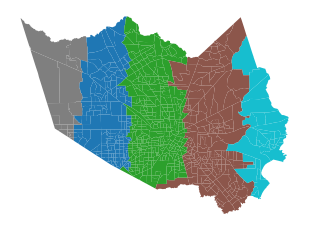

In [17]:
ax = harris.plot(column='region', categorical=True)
ax.set_axis_off()

In [18]:
w = libpysal.weights.block_weights(harris['region'])
gs = inequality.gini.Gini_Spatial(harris['MHI_2019'],w)

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


In [19]:
gs.p_sim

0.01

In [20]:
gs_all = [ inequality.gini.Gini_Spatial(harris["MHI_{}".format(year)], w) for year in years]

In [21]:
p_values = [gs.p_sim for gs in gs_all]
p_values

[0.01, 0.01, 0.01, 0.01, 0.01]

In [24]:
wgs = [gs.wcg_share for gs in gs_all]

In [23]:
bgs = [ 1 - wg for wg in wgs]

### 10 Plot the gini and spatial gini

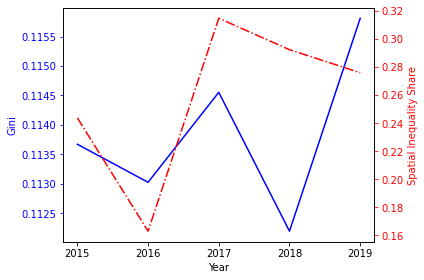

In [ ]:
fig, ax1 = plt.subplots()
t = years
s1 = ginis
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('Year')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Gini', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
s2 = bgs
ax2.plot(t, s2, 'r-.')
ax2.set_ylabel('Spatial Inequality Share', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()